# Model Development

In [1]:
# importing required Libraries
import pandas as pd
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import AdamW, Adam
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
warnings = warnings.filterwarnings("ignore")

In [3]:
# loading tweets

data = pd.read_csv(r"C:\Users\nvish\Desktop\Research\cleaned_tweets.csv")
data

,Tweets,Sentiment,Political_party
0,seeing future bjp spokesperson good luck anjan...,POSITIVE,BJP
1,trinamool congress sitting mp abhishek banerje...,NEGATIVE,BJP
2,loksabhaelections rd may reveal even ecisveep ...,NEGATIVE,BJP
3,loksabhaelections rd may reveal even could hel...,NEGATIVE,BJP
4,pm modi creates new record pm democratic count...,POSITIVE,BJP
...,...,...,...
139111,electioncommission loksabhaelections phase one...,NEGATIVE,Unknown
139112,early morning political move detailed discussi...,POSITIVE,Unknown
139113,cvoter predicts seat share upcoming loksabhael...,NEGATIVE,Unknown
139114,cvoter predicts seat share upcoming loksabhael...,NEGATIVE,Unknown


In [82]:
X = data['Tweets']
y = data['Sentiment']

# Support Vector Machine

In [83]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [84]:
X_tfidf = tfidf_vectorizer.fit_transform(X)

In [85]:
# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_tfidf, y)

In [86]:
# Split the data into 80% training and 30% testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

In [87]:
# Train the SVM model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

In [88]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred)*100)

Accuracy: 85.58327735162243


In [13]:
print("\n",classification_report(y_test, y_pred))


               precision    recall  f1-score   support

    NEGATIVE       0.86      0.85      0.86     21249
    POSITIVE       0.85      0.87      0.86     21424

    accuracy                           0.86     42673
   macro avg       0.86      0.86      0.86     42673
weighted avg       0.86      0.86      0.86     42673



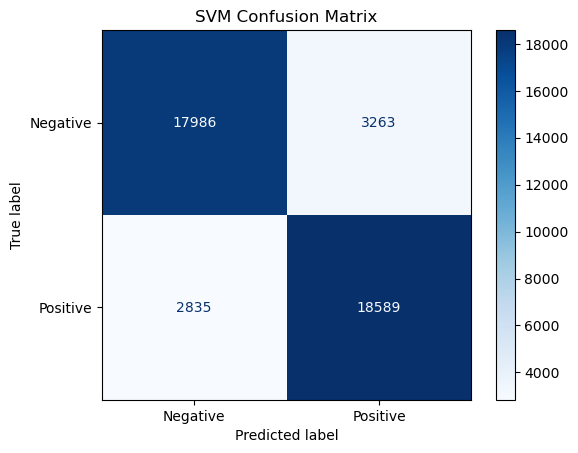

In [14]:
# Confusion Matrix for SVM
svm_cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(svm_cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title('SVM Confusion Matrix')
plt.show()

In [15]:
label_encoder = LabelEncoder()
label_encoder.fit(y)

LabelEncoder()

In [16]:
# It will Convert the values 'NEGATIVE' to 0 and 'POSITIVE' to 1
y_test_binary = label_encoder.transform(y_test)

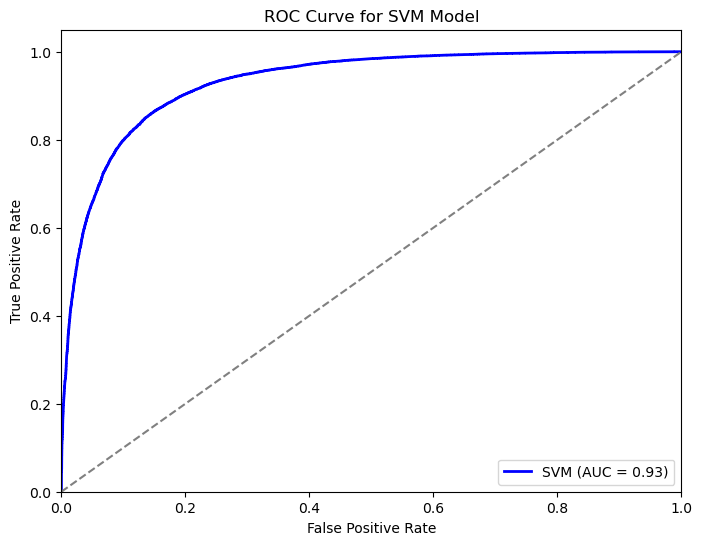

In [17]:
# SVM ROC Curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_binary, svm_model.decision_function(X_test))  # Get decision function scores
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plotting SVM ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Model')
plt.legend(loc='lower right')
plt.show()

# LSTM

In [63]:
y_labels = label_encoder.fit_transform(y)

In [64]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y_labels, test_size=0.3, random_state=42)

In [65]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train_lstm)

In [66]:
X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_test_seq = tokenizer.texts_to_sequences(X_test_lstm)

In [67]:
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [68]:
# Apply SMOTE for LSTM
X_train_pad_balanced, y_train_lstm_balanced = smote.fit_resample(X_train_pad, y_train_lstm)

In [69]:
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32, return_sequences=False),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

In [70]:
lstm_model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.001), metrics=['accuracy'])

In [71]:
# Train LSTM model
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint_path = "best_model.keras"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

In [24]:
history = lstm_model.fit(
    X_train_pad_balanced, y_train_lstm_balanced,
    validation_split=0.2,
    epochs=5,
    batch_size=128,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
609/609 ━━━━━━━━━━━━━━━━━━━━ 83s 131ms/step - accuracy: 0.8080 - loss: 0.4424 - val_accuracy: 0.8643 - val_loss: 0.3151
Epoch 2/5
609/609 ━━━━━━━━━━━━━━━━━━━━ 85s 139ms/step - accuracy: 0.8877 - loss: 0.2716 - val_accuracy: 0.8734 - val_loss: 0.3026
Epoch 3/5
609/609 ━━━━━━━━━━━━━━━━━━━━ 88s 144ms/step - accuracy: 0.9135 - loss: 0.2101 - val_accuracy: 0.8709 - val_loss: 0.3214
Epoch 4/5
609/609 ━━━━━━━━━━━━━━━━━━━━ 85s 140ms/step - accuracy: 0.9336 - loss: 0.1653 - val_accuracy: 0.8670 - val_loss: 0.3533
Epoch 5/5
609/609 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - accuracy: 0.9478 - loss: 0.1331 - val_accuracy: 0.8670 - val_loss: 0.4097


In [25]:
# Evaluate LSTM model
test_loss, test_accuracy = lstm_model.evaluate(X_test_pad, y_test_lstm)
print(f'Test Accuracy: {test_accuracy * 100}')

1305/1305 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.8705 - loss: 0.3028
Test Accuracy: 86.80963516235352


In [34]:
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

1305/1305 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step


In [27]:
print(classification_report(y_test_lstm, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92     31999
           1       0.76      0.64      0.69      9736

    accuracy                           0.87     41735
   macro avg       0.83      0.79      0.80     41735
weighted avg       0.86      0.87      0.86     41735



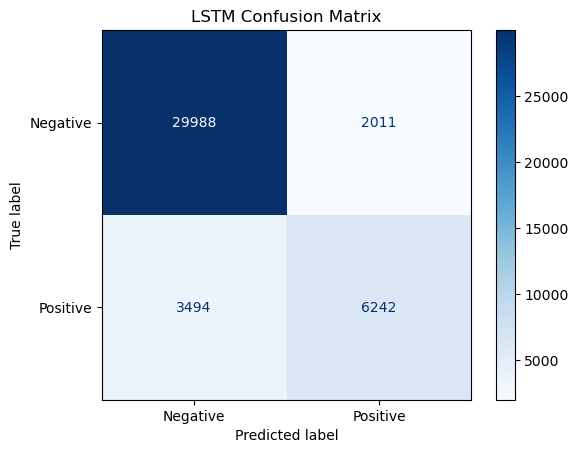

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_lstm, y_pred_lstm)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues', values_format='d')
plt.title('LSTM Confusion Matrix')
plt.show()

In [29]:
print(lstm_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ embedding (Embedding)         │ (None, 100, 128)      │    1,280,000 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm (LSTM)                   │ (None, 100, 64)       │       49,408 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 100, 64)       │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm_1 (LSTM)                 │ (None, 32)            │       12,416 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_1 (Dropout)           │ (None, 32)            │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 1)             │           33 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 4,025,573 (15.36 MB)

 Trainable params: 1,341,857 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,683,716 (10.24 MB)

None


In [30]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

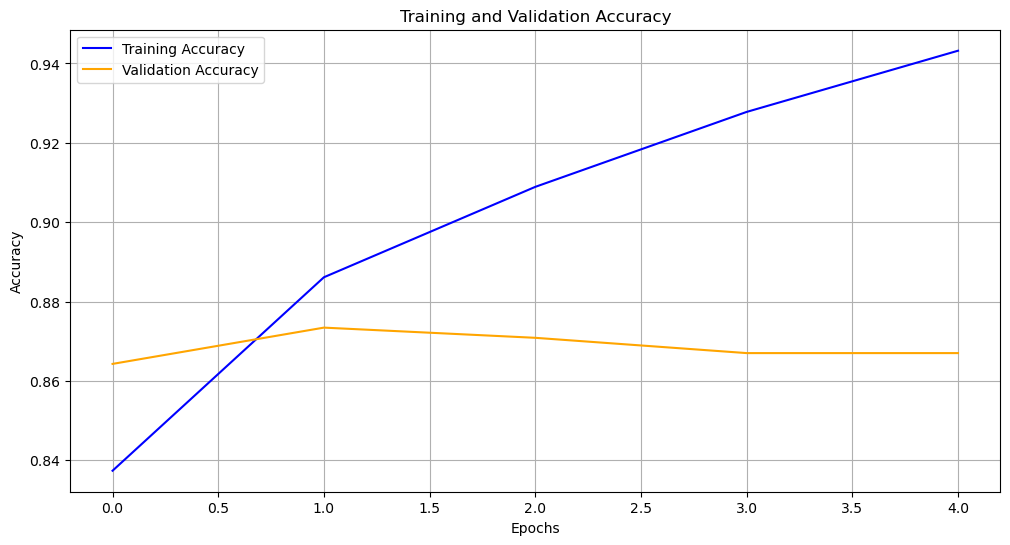

In [31]:
# Plot Accuracy Curves
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [32]:
# Get probabilities for LSTM (using sigmoid outputs)
y_pred_lstm_prob = lstm_model.predict(X_test_pad)

1305/1305 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step


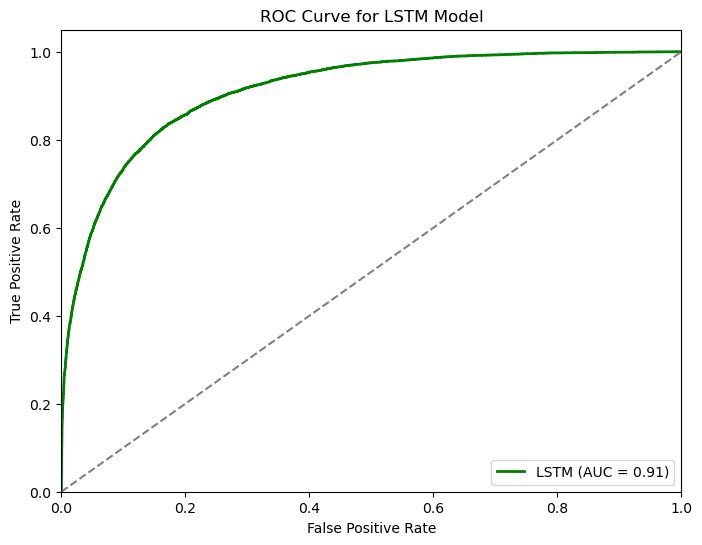

In [33]:
# ROC Curve for LSTM
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test_lstm, y_pred_lstm_prob)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Plot ROC curve for LSTM
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='green', lw=2, label=f'LSTM (AUC = {roc_auc_lstm:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LSTM Model')
plt.legend(loc='lower right')
plt.show()